## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-21 07:25:38--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2023-05-21 07:25:38 (105 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [3]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)
import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

**Let's start with preprocessing**

**❣ Big part of this notebook was done with usage of open sourses, such as Pytorch Tutorials and Stepik's github**

In [7]:
# !pip install youtokentome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for youtokentome: filename=youtokentome-1.0.6-cp310-cp310-linux_x86_64.whl size=1927511 sha256=c9e261b199aacd46a530f604afd09d1dd9534cf47c2cdc0b388cfbafc092a48a
  Stored in directory: /root/.cache/pip/wheels/df/85/f8/301d2ba45f43f30bed2fe413efa760bc726b8b660ed9c2900c
Successfully built youtokentome


In [8]:
# !pip install git+https://github.com/PetrochukM/PyTorch-NLP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PetrochukM/PyTorch-NLP.git to /tmp/pip-req-build-8he634lz
  Running command git clone --filter=blob:none --quiet https://github.com/PetrochukM/PyTorch-NLP.git /tmp/pip-req-build-8he634lz
  Resolved https://github.com/PetrochukM/PyTorch-NLP.git to commit d7814a297811c9b0dfb285fe0475098b86f3d348
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-nlp: filename=pytorch_nlp-0.5.0-py3-none-any.whl size=88342 sha256=5d9bda0e826b3cf0d6ed32a172fe49fd7e328599f9803b1a5654cd9526346aa6
  Stored in directory: /tmp/pip-ephem-wheel-cache-i74ssfvh/wheels/a5/93/b0/9f0138afb1271281613a5af71272c5b246fdd2d421c6fbdf88
Successfully built pytorch-nlp


In [9]:
import numpy as np
import youtokentome as yttm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import random
import time
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
from nltk.translate.bleu_score import corpus_bleu
from torch.nn import Transformer
import torchnlp.nn as nlpnn

In [10]:
with open('data.txt', 'r') as f:
    data = [ex.rstrip().split("\t") for ex in f]

The `data.txt` is a tsv file, each line of which contains a sentence in english and a corresponding translation, separated by `\t`. We'll load it into memory and create a list of pairs, which would yield the same interface as with the torchtext's datasets.

In [11]:
with open("data.txt") as f:
    data = [l.rstrip().split("\t") for l in f]
    data = [[sent.lower() for sent in pair] for pair in data]
data[:5]

[['cordelia hotel is situated in tbilisi, a 3-minute walk away from saint trinity church.',
  'отель cordelia расположен в тбилиси, в 3 минутах ходьбы от свято-троицкого собора.'],
 ['at tupirmarka lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'в числе удобств лоджа tupirmarka круглосуточная стойка регистрации и снэк-бар. гости могут воспользоваться услугой доставки еды и напитков в номер.'],
 ['featuring free wifi in all areas, naigao xiaowo offers accommodation in shanghai.',
  'апартаменты naigao xiaowo расположены в городе шанхай. к услугам гостей бесплатный wi-fi во всех зонах.'],
 ['each has a tv and a private bathroom with shower.',
  'в вашем распоряжении также телевизор и собственная ванная комната с душем.'],
 ['your room comes with air conditioning and satellite tv.',
  'номер оснащен кондиционером и спутниковым телевидением.']]

In [12]:
np.random.shuffle(data)

train_size = int(len(data) * 0.8)
valid_size = int(len(data) * 0.15)

train_data = np.array(data[:train_size])
valid_data = np.array(data[train_size:train_size+valid_size])
test_data = np.array(data[train_size+valid_size:])

print('Size of train data:', len(train_data))
print('Size of validation data:', len(valid_data))
print('Size of test data:', len(test_data))

Size of train data: 40000
Size of validation data: 7500
Size of test data: 2500


In [13]:
train_data[:5]

array([['in the centre of petrovac and along a seaside promenade guests can found various restaurants and bars.',
        'в центре петроваца и вдоль приморской набережной располагаются различные рестораны и бары.'],
       ['located in the centre of kastoria, doltso, venetula is a neoclassical guesthouse overlooking the lake.',
        'гостевой дом venetula построен в неоклассическом стиле и расположен в центре кастории (долтсо). из него открывается вид на озеро.'],
       ['a wide variety of restaurants and cafés are located within a 10-minute walk.',
        'кроме того, в пределах 10 минут ходьбы работают различные рестораны и кафе.'],
       ['this motel features an outdoor pool and spacious accommodation with a kitchenette and dvd player. pirates bay water park is just 5 minutes’ drive from scottish inn & suites baytown.',
        'мотель scottish inn and suites baytown находится всего в 5 минутах езды от аквапарка «пайретс бэй» и располагает просторными номерами с мини-кухней и

In [14]:
# tokenize with BPE
# use the library from VK command written not on Python
# possibly, it's most effective to use text files for communication

src_train_filename = 'data_for_BPE_src.txt'
trg_train_filename = 'data_for_BPE_trg.txt'
src_bpe_model_filename = 'model_BPE_src.yttm'
trg_bpe_model_filename = 'model_BPE_trg.yttm'

with open(src_train_filename, 'w') as f:
  f.write('\n'.join(train_data[:, 0]))

with open(trg_train_filename, 'w') as g:
  g.write('\n'.join(train_data[:, 1]))

yttm.BPE.train(data=src_train_filename, vocab_size=8000, model=src_bpe_model_filename)
src_tokenizer = yttm.BPE(src_bpe_model_filename)

yttm.BPE.train(data=trg_train_filename, vocab_size=8000, model=trg_bpe_model_filename)
trg_tokenizer = yttm.BPE(trg_bpe_model_filename)

src_train_token_ids = src_tokenizer.encode(list(train_data[:, 0]), bos=True, eos=True)
src_valid_token_ids = src_tokenizer.encode(list(valid_data[:, 0]), bos=True, eos=True)
src_test_token_ids = src_tokenizer.encode(list(test_data[:, 0]), bos=True, eos=True)

trg_train_token_ids = trg_tokenizer.encode(list(train_data[:, 1]), bos=True, eos=True)
trg_valid_token_ids = trg_tokenizer.encode(list(valid_data[:, 1]), bos=True, eos=True)
trg_test_token_ids = trg_tokenizer.encode(list(test_data[:, 1]), bos=True, eos=True)

In [15]:
print(trg_tokenizer.encode('солнце зашло за горизонт'))
print(src_tokenizer.encode('the sun has set over the horizon'))

[6286, 1297, 235, 41, 251, 235, 190, 257, 1797, 8]
[173, 736, 451, 568, 810, 173, 6364]


In [16]:
print(trg_tokenizer.vocab()[1785], src_tokenizer.vocab()[6411])

▁которых ▁staircas


In [17]:
print(' '.join(src_tokenizer.vocab()))
print(' '.join(trg_tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e a t i r o n s l h d c m f u p . g w b v y k , - 0 1 2 j 5 q x z 4 3 ’ ' 6 7 8 é 9 & / ) ( á ó ü ö í ä ô à ã : š ł ç ñ č ø è å " â ń – ú ́ ś ž ć ; æ ß î ş ê ı ě ý ë ę ř ù ” а ą “ ů ī ! ă @ % ‘ о и ò + т е ň р к ż ā д ğ đ ï н м ̇ ő ė ì ® с л ʼ ū ľ ē û ` ы п й õ * ч в ș ŭ ţ ņ °  # • я ь х у г б τ ̊ ź ű ť œ ļ ķ ĭ  ▁a th in re ▁f ro ▁s te ▁th nd ▁the is ▁c ▁w ▁and er ▁b ▁p ▁o en es ar ▁is an ing om ▁wi ▁m ▁h it on at or ▁t al ▁in ▁d le ▁l ou ▁k ▁of ▁with ri ac ate ▁fro il ed room res ▁from ▁g ion as et ▁are ay ur ent ir ree ll ▁free ▁km ic ▁e riv ▁pro ▁room ▁ho ▁off ta ▁v ble ▁1 ts ▁to ation ▁at ▁air eat ▁ba way ter ers tel ach ▁can ch ort ty able ▁lo us ▁bath ute ge ▁sh ls ues id ated inute ▁be ▁away ▁2 ▁st ▁on ite per ail ▁hotel ▁n ▁gues ▁loc ▁re ▁feat ol ment ark ▁tv ▁ac ud ▁offers ▁rooms ▁proper ▁property ▁res ▁priv cl ▁private art ak un ve fi qu od port ▁ap ▁bathroom ▁an ▁av ies -s ▁airport ▁avail ▁available ▁away. ▁park -m clud ▁located ▁includ our ▁acc ▁

In [18]:
# save service token into separate tokens for more convinient
PAD_token = 0
UNK_token = 1
BOS_token = 2
EOS_token = 3

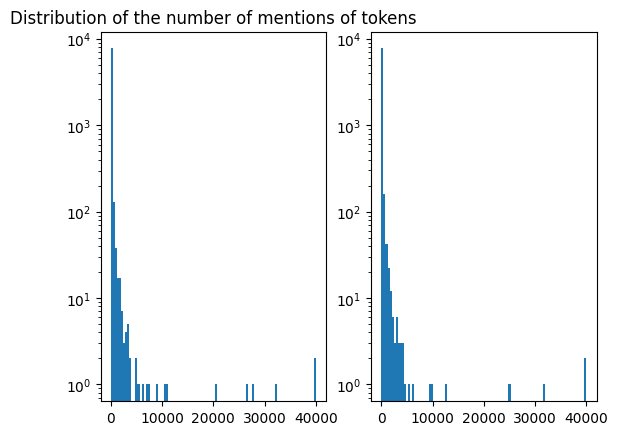

In [19]:
# Let's look should we correct the vocabularity size or not
src_token_counts = np.bincount([token_id for text in src_train_token_ids for token_id in text])
plt.subplot(1,2,1)
plt.hist(src_token_counts, bins=100)
plt.title('Distribution of the number of mentions of tokens')
plt.yscale('log')

trg_token_counts = np.bincount([token_id for text in trg_train_token_ids for token_id in text])
plt.subplot(1,2,2)
plt.hist(trg_token_counts, bins=100)
plt.yscale('log')

In [20]:
# The number of unknown tokens in validation
print(sum(1 for text in src_valid_token_ids for token_id in text if token_id == 1))
print(sum(1 for text in trg_valid_token_ids for token_id in text if token_id == 1))

2
2


In [21]:
def collate_batch(batch):
    src_list, trg_list = [], []
    for src_batch, trg_batch in batch:
        src_encoded = src_tokenizer.encode(src_batch)
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = trg_tokenizer.encode(trg_batch)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list)
    trg_padded = pad_sequence(trg_list)
    return src_padded, trg_padded

batch_size = 250
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_data, batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate_batch)

In [22]:
def indexesFromSentence(tokenizer, sentence):
    return tokenizer.encode(sentence)

def tensorFromSentence(tokenizer, sentence):
    indexes = indexesFromSentence(tokenizer, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    src_tensor = tensorFromSentence(src_tokenizer, pair[0])
    trg_tensor = tensorFromSentence(trg_tokenizer, pair[1])
    return (src_tensor, trg_tensor)

def init_weights(m):
    for name, param in m.named_parameters():
        if param.dim() > 1:
          nn.init.xavier_uniform_(param)
        else:
          nn.init.uniform_(param, -0.08, 0.08)
        
def merge_tokens(tokens):
    if tokens == []:
        return []
    merged_tokens = [tokens[0]]
    for i in range(1, len(tokens)):
        if tokens[i][:2] == "##":
            merged_tokens[-1] += tokens[i][2:]
        else:
            merged_tokens.append(tokens[i])
    return merged_tokens

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Firstly, let's try to fine-tune existed model from HuggingFace**

In [ ]:
# ! pip install datasets transformers[sentencepiece] sacrebleu
# !apt install git-lfs

# import transformers
# print(transformers.__version__)

In [ ]:
# from transformers.utils import send_example_telemetry
# send_example_telemetry("translation_notebook", framework="pytorch")

In [ ]:
# model_checkpoint = "Helsinki-NLP/opus-mt-en-ru"
# from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

# model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
# batch_size = 16
# model_name = model_checkpoint.split("/")[-1]
# args = Seq2SeqTrainingArguments(
#     f"{model_name}-finetuned-english-to-russian",
#     evaluation_strategy = "epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     weight_decay=0.01,
#     save_total_limit=3,
#     num_train_epochs=1,
#     predict_with_generate=True,
#     fp16=True,
#     push_to_hub=True,
# )

*There were some problems with coonection of this model and my data and tokenizer, so this part not really done yet (may be, once...)*

**Seq-to-seq model may be good enough, with its relative simplicity**

In [24]:
# Encoder is GRU (for every word returns vector and hidden state)
class Encoder(nn.Module):
    def __init__(self, n_tokens, emb_size, hidden_size, n_layers, dropout, use_attention = False):
        super().__init__()

        # super(Encoder, self).__init__()
        # self.hidden_size = hidden_size

        # self.embedding = nn.Embedding(input_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size)

        self.n_tokens = n_tokens
        self.hid_dim = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(emb_size, hidden_size, n_layers, dropout=dropout)

        self.use_attention = use_attention

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded)
        if self.use_attention:
            return output, hidden
        return hidden

    # def initHidden(self):
    #     return torch.zeros(1, 1, self.hidden_size, device=device)

In [25]:
# Decoder is GRU (takes the encoder output vectors and outputs a sequence of words)
class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_size, hidden_size, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_size, hidden_size, n_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size, n_tokens)

    def forward(self, input, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        output, hidden = self.rnn(embedded, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden

    # def initHidden(self):
    #     return torch.zeros(1, 1, self.hidden_size, device=device)

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, use_attention=False):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.use_attention = use_attention

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        if self.use_attention:
            encoder_outputs, hidden = self.encoder(src)
        else:
            hidden = self.encoder(src)

        input = trg[0, :]
        for i in range(1, trg_len):
            if self.use_attention:
                pred, hidden = self.decoder(input, encoder_outputs, hidden)
            else:
                pred, hidden = self.decoder(input, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [27]:
encoder1 = Encoder(8000, emb_size=512, hidden_size=512, n_layers=3, dropout=0.3)
decoder1 = Decoder(8000, emb_size=512, hidden_size=512, n_layers=3, dropout=0.3)
model1 = Seq2Seq(encoder1, decoder1).to(device)
model1.apply(init_weights)

In [29]:
def train(model, n_epochs=40):
    start = time.time()
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)
    loss_history, train_loss_history, val_loss_history = [], [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for src, trg in train_dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)
            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_loss += loss.item()
            loss_history.append(loss.item())

            if len(loss_history) % 10 == 0:
                clear_output(wait=True)

                plt.figure(figsize=(16, 5))

                plt.subplot(121)
                plt.plot(loss_history)
                plt.xlabel("steps")

                plt.subplot(122)
                plt.plot(train_loss_history, label="train loss")
                plt.plot(val_loss_history, label="validation loss")
                plt.xlabel("epochs")
                plt.legend()

                plt.show()

        print('passed time: ', time.time()-start, 'epoch: ', epoch)

        train_loss /= len(train_dataloader)
        train_loss_history.append(train_loss)

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for src, trg in valid_dataloader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg)

                output = output.view(-1, output.shape[-1])
                trg = trg[1:].view(-1)

                loss = criterion(output, trg)

                valid_loss += loss.item()

        valid_loss /= len(valid_dataloader)
        val_loss_history.append(valid_loss)

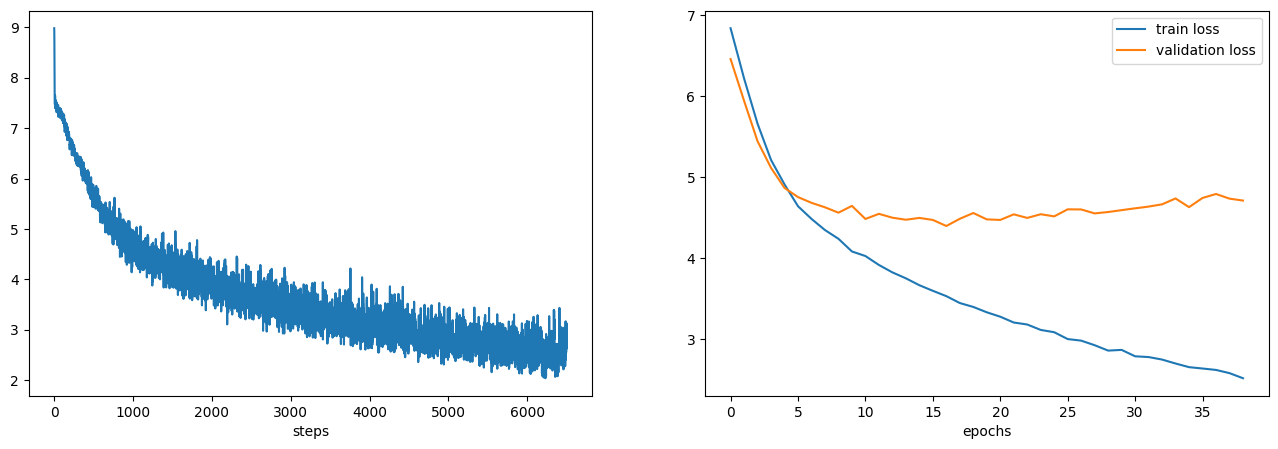

passed time:  3685.5462775230408 epoch:  39


In [70]:
train(model1)

**We can add the Attention with not large expenses**

In [30]:
# calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs
class AttentionDecoder(nn.Module):
    def __init__(self, n_tokens, emb_size, hidden_size, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.attn = nlpnn.Attention(hidden_size)
        self.embedding = nn.Embedding(n_tokens, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(emb_size + hidden_size, hidden_size, n_layers, dropout=dropout)
        # self.attn = nn.MultiheadAttention(hid_dim, 64)
        self.out = nn.Linear(hidden_size, n_tokens)

    def forward(self, input, encoder_outputs, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        context, _ = self.attn(hidden[-1].unsqueeze(1), encoder_outputs.swapaxes(0, 1))
        context = context.swapaxes(0, 1)

        rnn_input = torch.cat((embedded, context), dim=-1)
        output, hidden = self.gru(rnn_input, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden

In [32]:
encoder2 = Encoder(8000, emb_size=512, hidden_size=512, n_layers=3, dropout=0.3, use_attention = True)
decoder2 = AttentionDecoder(8000, emb_size=512, hidden_size=512, n_layers=3, dropout=0.3)
model2 = Seq2Seq(encoder2, decoder2, use_attention=True).to(device)

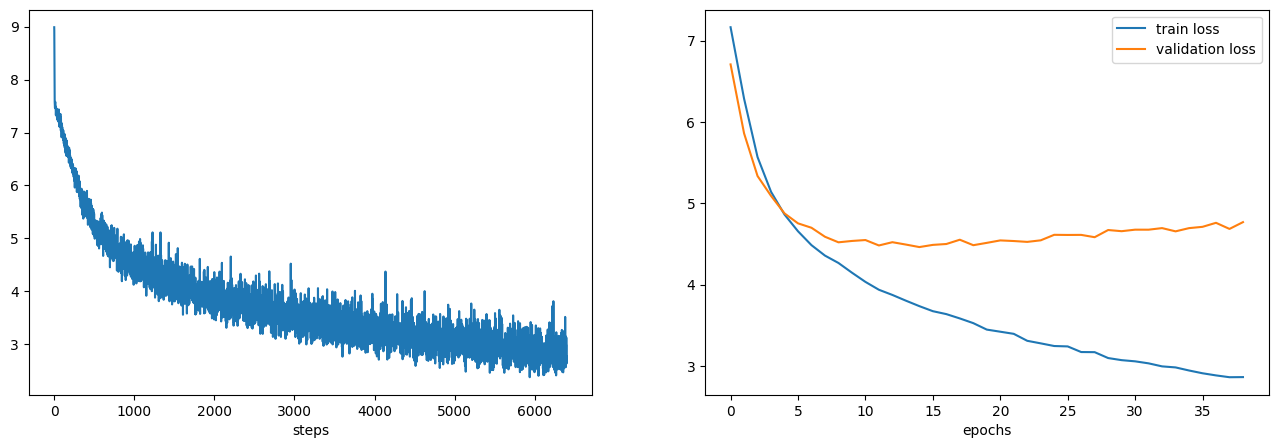

passed time:  4588.773192405701 epoch:  39


In [33]:
train(model2)

In [ ]:
# def evaluate1(encoder, decoder, sentence, max_length=50):
#     with torch.no_grad():
#         input_tensor = tensorFromSentence(src_tokenizer, sentence)
#         input_length = input_tensor.size()[0]
#         encoder_hidden = encoder.initHidden()

#         encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

#         for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei],
#                                                      encoder_hidden)
#             encoder_outputs[ei] += encoder_output[0, 0]

#         decoder_input = torch.tensor([[BOS_token]], device=device)

#         decoder_hidden = encoder_hidden

#         decoded_words = []
#         decoder_attentions = torch.zeros(max_length, max_length)

#         for di in range(max_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             decoder_attentions[di] = decoder_attention.data
#             topv, topi = decoder_output.data.topk(1)
#             if topi.item() == EOS_token:
#                 decoded_words.append('<EOS>')
#                 break
#             else:
#                 decoded_words.append(trg_tokenizer.vocab()[topi.item()])

#             decoder_input = topi.squeeze().detach()

#         return decoded_words, decoder_attentions[:di + 1]

In [40]:
def evaluate(model, use_attention=False):
  model.eval()
  max_len = 30
  iter = 0
  with torch.no_grad():
      for i, (src, trg) in enumerate(valid_data):
          encoded = src_tokenizer.encode(src)[::-1]
          encoded = torch.tensor(encoded)[:, None].to(device)
          output, hidden = model.encoder(encoded)
          pred_tokens = [BOS_token] # first preddicted element is starting token

          for _ in range(max_len):
              decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
              if use_attention:
                pred, hidden = model.decoder(decoder_input, output, hidden)
              else:
                pred, hidden = model.decoder(decoder_input, hidden)
              _, pred_token = pred.max(dim=1)
              if pred_token == EOS_token:
                  break

              pred_tokens.append(pred_token.item())

          print('eng: ', src.rstrip())
          print('rus: ', trg.rstrip())
          print('pred: ', trg_tokenizer.decode(pred_tokens))
          print()

          if iter == 7:
              break

          iter+=1

In [107]:
evaluate(model1)

eng:  dachstein west ski area can be reached within 15 km.
rus:  до горнолыжного курорта дахштайн-вест 15 км.
pred:  ['<BOS> находится в в км от гостевого дома.......................']

eng:  hotel saint yves lies close to the centre of nantes, a 10 minute walk from saint pierre cathedral and chateau des ducs de bretagne.
rus:  отель saint yves находится недалеко от центра города нант, в 10 минутах ходьбы от собора сен-пьер и шато-де-дюк-де-бретань.
pred:  ['<BOS> отеля géreéisééééé находятся в нескольких минутах ходьбы от торговой торговой гескихов и и торговой улицы гарда.ц..']

eng:  the property is 8 km from praia do meireles beach, 10.9 km from praia da iracema beach and 1.6 km from beach park.
rus:  расстояние до пляжа мейрелис составляет 8 км, до пляжа ирасема — 10,9 км, а в 1,6 км открыт аквапарк beach park.
pred:  ['<BOS> курортного отеля «мор находится в 4,1 км от пляжа «морский пляж кацентр и пляж кала-центр» — в км. км. км. км. км.']

eng:  downtown penthouse is air-conditi

In [41]:
evaluate(model2, use_attention=True)

eng:  cruises to malta can also be organised.
rus:  по желанию гостей могут быть организованы круизы до мальты.
pred:  ['<BOS>минана.о.о.джео.о.ми.ми.с.с.с.с.с. можно дойти за минут. минут. минут. минут. минут. минут. минут. минут. минут.ми.ми.ми. минут.']

eng:  the property is 30 km from bastia - poretta airport and 25 km from the bastia port with ferry access to the mainland.
rus:  апартаменты расположены в 30 км от аэропорта бастия-поретта и в 25 км от порта бастии, откуда отправляются паромы к материку.
pred:  ['<BOS> познакомиться и паромного порта находятся в в 1 км от комплекса. для отпуска можно добраться до города дубровника. аэропорт дубровника составляет 28 км. км. км. км. км. от комплекса.']

eng:  the daily breakfast is a sweet and savoury buffet.
rus:  для гостей сервируется завтрак «шведский стол», состоящий из закусок и сладостей.
pred:  ['<BOS>ный «шведский стол». стол». в числе гостей накрывают сладкий завтрак. завтрак. завтрак.сти..сти..сти..сти..сти..сти..сти..сти.

In [42]:
# seems like model cycles to a certain sentence length (??)

**Finally, we will try to use Transformer**

*Before this version, it was trained and evaluated on another tokenizer (suggested in pytorch tutorial)*

In [45]:
# from typing import Tensor

# class Seq2SeqTransformer(nn.Module):
#     def __init__(self,
#                  num_encoder_layers: int,
#                  num_decoder_layers: int,
#                  emb_size: int,
#                  nhead: int,
#                  src_vocab_size: int,
#                  tgt_vocab_size: int,
#                  dim_feedforward: int = 512,
#                  dropout: float = 0.1):
#         super(Seq2SeqTransformer, self).__init__()
#         self.transformer = Transformer(d_model=emb_size,
#                                        nhead=nhead,
#                                        num_encoder_layers=num_encoder_layers,
#                                        num_decoder_layers=num_decoder_layers,
#                                        dim_feedforward=dim_feedforward,
#                                        dropout=dropout)
#         self.generator = nn.Linear(emb_size, tgt_vocab_size)
#         self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
#         self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
#         self.positional_encoding = PositionalEncoding(
#             emb_size, dropout=dropout)
        
#     def forward(self,
#                 src,
#                 trg,
#                 src_mask,
#                 tgt_mask,
#                 src_padding_mask,
#                 tgt_padding_mask,
#                 memory_key_padding_mask):
#         src_emb = self.positional_encoding(self.src_tok_emb(src))
#         tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
#         outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
#                                 src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
#         return self.generator(outs)

#     def encode(self, src, src_mask):
#         return self.transformer.encoder(self.positional_encoding(
#                             self.src_tok_emb(src)), src_mask)

#     def decode(self, tgt, memory, tgt_mask):
#         return self.transformer.decoder(self.positional_encoding(
#                           self.tgt_tok_emb(tgt)), memory,
#                           tgt_mask)

In [59]:
# import math
# torch.manual_seed(0)

# SRC_VOCAB_SIZE = 8000
# TGT_VOCAB_SIZE = 8000
# EMB_SIZE = 512
# NHEAD = 8
# FFN_HID_DIM = 512
# BATCH_SIZE = 128
# NUM_ENCODER_LAYERS = 3
# NUM_DECODER_LAYERS = 3

# model3 = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
#                                  NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM).to(device)
# model3.apply(init_weights)

In [ ]:
class PositionalEncoding(nn.Module): # helper Module that adds positional encoding to the token embedding to introduce a notion of word order
    def __init__(self, emb_size, dropout, maxlen=5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [ ]:
class TokenEmbedding(nn.Module): # helper Module to convert tensor of input indices into corresponding tensor of token embeddings
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [55]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, trg_vocab_size, dim_feedforward = 512, dropout=0.1):
        super().__init__()
        self.transformer = nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = nn.Linear(emb_size, trg_vocab_size)
        self.src_token_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.trg_token_emb = TokenEmbedding(trg_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src, trg, src_mask=None, trg_mask=None, src_padding_mask=None, trg_padding_mask=None, memory_key_padding_mask=None):
        src_emb = self.positional_encoding(self.src_token_emb(src))
        trg_emb = self.positional_encoding(self.trg_token_emb(trg))
        outs = self.transformer(src_emb, trg_emb, src_mask, trg_mask, None, src_padding_mask, trg_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask=None):
        return self.transformer.encoder(self.positional_encoding(self.src_token_emb(src)), src_mask)

    def decode(self, trg, memory, trg_mask=None):
        return self.transformer.decoder(self.positional_encoding(self.trg_token_emb(trg)), memory, trg_mask)

In [ ]:
# subsequent word mask that will prevent the model from looking into the future words when making predictions

def generate_square_subsequent_mask(sz, device):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, trg, device):
    src_seq_len = src.shape[0]
    trg_seq_len = trg.shape[0]

    trg_mask = generate_square_subsequent_mask(trg_seq_len, device)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == PAD_token).transpose(0, 1)
    trg_padding_mask = (trg == PAD_token).transpose(0, 1)
    return src_mask, trg_mask, src_padding_mask, trg_padding_mask

In [56]:
model3 = Seq2SeqTransformer(3, 3, 512, 8, 8000, 8000, 512).to(device)
model3.apply(init_weights)

optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)
loss_history, train_loss_history, val_loss_history = [], [], []

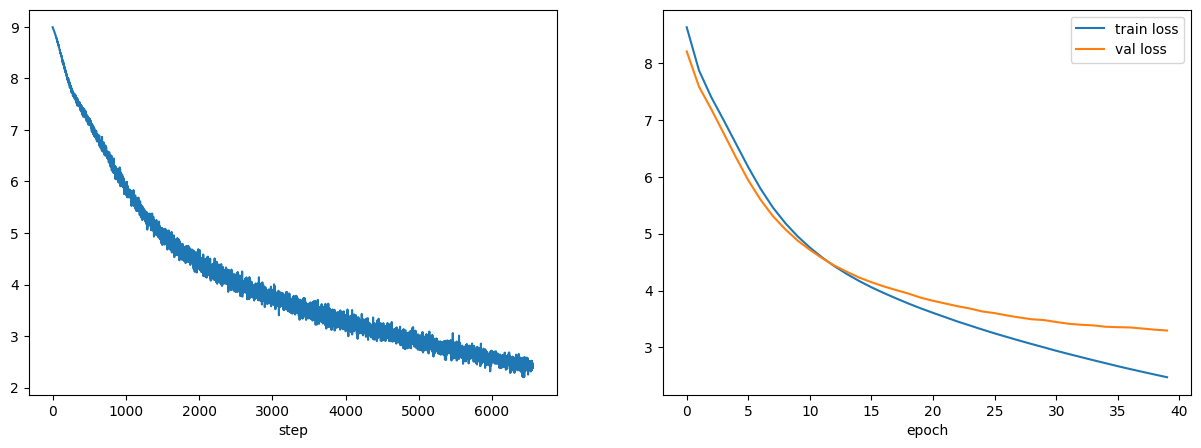

In [58]:
n_epochs = 40
for epoch in range(n_epochs):
    model3.train()
    train_loss = 0
    for src, trg in train_dataloader:
        src, trg = src.to(device), trg.to(device)
        trg_input = trg[:-1, :]

        src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_mask(src, trg_input, device)

        output = model3(src, trg_input, src_mask=src_mask, trg_mask=trg_mask, src_padding_mask=src_padding_mask, trg_padding_mask=trg_padding_mask, memory_key_padding_mask=src_padding_mask)

        output = output.view(-1, output.shape[-1])
        trg_out = trg[1:, :].view(-1)

        loss = criterion(output, trg_out)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model3.parameters(), 1)
        optimizer.step()

        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(val_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model3.eval()
    valid_loss = 0
    with torch.no_grad():
        for src, trg in valid_dataloader:
            src, trg = src.to(device), trg.to(device)
            trg_input = trg[:-1, :]

            src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_mask(src, trg_input, device)

            output = model3(src, trg_input, src_mask=src_mask, trg_mask=trg_mask, src_padding_mask=src_padding_mask,
                            trg_padding_mask=trg_padding_mask, memory_key_padding_mask=src_padding_mask)

            output = output.view(-1, output.shape[-1])
            trg_out = trg[1:, :].view(-1)

            loss = criterion(output, trg_out)

            valid_loss += loss.item()

    valid_loss /= len(valid_dataloader)
    val_loss_history.append(valid_loss)

In [90]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol, device=device):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_token:
            break
    return ys

# actual function to translate input sentence into target language
# def translate(model: torch.nn.Module, src_sentence: str):
#     model.eval()
#     src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
#     num_tokens = src.shape[0]
#     src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
#     tgt_tokens = greedy_decode(
#         model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
#     return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [92]:
def translate(model, src_sentence, max_len, device=device):
    model.eval()
    src = src_tokenizer.encode(src_sentence)
    src = torch.tensor(src)[:, None].to(device)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    memory = model.encode(src, src_mask)
    # num_tokens = src.shape[0]

    # src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model, src, src_mask, max_len, BOS_token, device)
    return trg_tokenizer.decode([i for i in tgt_tokens[1:]]) 

## Model evaluation

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, device):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len - 1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0), device).type(torch.bool)).to(device)

        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        if next_word == trg_eos_token_id:
            break

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)

    return ys


def translate(model, src_sentence, device, max_len):
    model.eval()
    src = encode(src_sentence, 'src')[::-1]
    src = torch.tensor(src)[:, None].to(device)
    memory = model.encode(src)
    num_tokens = src.shape[0]

    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model, src, src_mask, max_len, trg_sos_token_id, device)
    return trg_tokenizer.decode([i for i in tgt_tokens[1:]]) 

In [ ]:
model3.eval()
max_len = 50
with torch.no_grad():
    for i, (src, trg) in enumerate(valid_data):
        pred = translate(model3, src, device, max_len)

        print('src: ', src.rstrip())
        print('trg: ', trg.rstrip()')
        print('pred: ', pred)
        print()

        if i == 10:
            break

src: 'all apartments have a dvd player and satellite tv, a kitchen with a microwave, and a washing machine and a tumble dryer.'
trg: 'все они оснащены телевизором со спутниковыми каналами и dvd-плеером, а также располагают кухней с микроволновой печью и стиральной/сушильной машиной.'
pred: 'в числе удобств апартаментов стиральная машина, телевизор, dvd - плеер, стиральная машина и полностью оборудованная кухня с микроволновой печью и холодильником.'

src: 'they are fitted with blackout curtains, free drinking water and free toiletries.'
trg: 'гостям предоставляется бесплатная питьевая вода и бесплатные туалетно-косметическими принадлежности.'
pred: 'в стоимость проживания входит карта, а также другие удобства, включая бесплатные туалетно - косметические принадлежности и халаты.'

src: 'a small refrigerator, coffee-making facilities and a work desk are included.'
trg: 'к услугам гостей также небольшой холодильник, принадлежности для кофе и рабочий стол.'
pred: 'в каждом номере имеется н

In [ ]:
references, hypotheses = [], []
with torch.no_grad():
    for src, trg in test_dataloader:
        src = src.to(device)
        trg = trg.to(device)
        trg_input = trg[:-1, :]
        src_mask, trg_mask, src_padding_mask, trg_padding_mask = create_mask(src, trg_input, device)

        output = model(src, trg_input, src_mask=src_mask, trg_mask=trg_mask, src_padding_mask=src_padding_mask,
                       trg_padding_mask=trg_padding_mask, memory_key_padding_mask=src_padding_mask)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            reference = trg[:, i]
            reference_tokens = [trg_tokenizer.vocab()[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in trg_tokenizer.vocab()[:4]]
            reference_tokens = merge_tokens(reference_tokens)
            references.append(reference_tokens)

            hypothesis = output[:, i]
            hypothesis = [id_ for id_ in hypothesis]
            if EOS_token in hypothesis:
                hypothesis = hypothesis[:hypothesis.index(EOS_token)]
            hypothesis_tokens = [trg_tokenizer.vocab()[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in trg_tokenizer.vocab()[:4]]
            hypothesis_tokens = merge_tokens(hypothesis_tokens)
            hypotheses.append(hypothesis_tokens)

bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print('Your model shows test BLEU of', round(100 * bleu, 1))

Your model shows test BLEU of 29.7
